In [114]:

from typing import List
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from package.HmmTSModel import HmmTimeSeriesModel
from TM_members_study.Esmond import financial_data as fd
import matplotlib.pyplot as plt

In [172]:
%load_ext autoreload
%autoreload
from package.HmmTSModel import HmmTimeSeriesModel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [176]:
def train_model(model, data: pd.DataFrame, **kwargs):
    model.fit(data,**kwargs)
    
def test_model(model, data: pd.DataFrame, **kwargs):
    prediction = model.project(data, **kwargs)
    data_list = data['close']
    return r2_score(data_list[1:], prediction)

In [177]:
if __name__ == "__main__":
    
    HMM_stock_predictor = HmmTimeSeriesModel(n_hidden_states=5,n_iter=1000,covariance_type='full',n_latency=3)
    
    GME_TRAIN = fd.get_financial_time_series("GME", "2020-01-01", "2021-01-01", 
                                             ['Open', 'High', 'Low', 'Close','Volume']).dropna()
    GME_TEST = fd.get_financial_time_series("GME", "2021-01-01", "2021-02-08", ['Open', 'High', 'Low', 'Close','Volume']).dropna()
    
    train_model(HMM_stock_predictor, GME_TRAIN, step=[20,10,10,5,10])
    
    print(test_model(HMM_stock_predictor, GME_TEST))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,frac_change,frac_high,frac_low,vol_gap
Date,,,,
2020-01-03,-0.053140,0.006441,0.059581,-0.204262
2020-01-06,0.008621,0.018965,0.034483,-0.042072
2020-01-07,-0.043328,0.010399,0.057192,0.540002
2020-01-08,0.041894,0.065574,0.014572,0.076779
2020-01-09,-0.046392,0.000000,0.058419,-0.530501
...,...,...,...,...
2020-12-24,-0.040933,0.022370,0.050452,-0.757564
2020-12-28,-0.015016,0.030971,0.045049,0.431749
2020-12-29,-0.069164,0.012008,0.108549,0.030728


100%|██████████| 23/23 [02:46<00:00,  7.23s/it]

0.8790773432081639


In [175]:
GME_TEST = fd.get_financial_time_series("GME", "2021-01-01", "2021-01-8", ['Open', 'High', 'Low', 'Close','Volume']).dropna()

GME_TEST.columns= GME_TEST.columns.str.strip().str.lower()
data = GME_TEST.copy()

data['frac_change'] = (np.array(data['close']) - np.array(data['open'])) / np.array(data['open'])
data['frac_high'] = (np.array(data['high']) - np.array(data['open'])) / np.array(data['open'])
data['frac_low'] = (np.array(data['open']) - np.array(data['low'])) / np.array(data['open'])

forecast_var = np.array(data['open'].pct_change())
vol_gap = np.array(data['volume'].pct_change())

[*********************100%***********************]  1 of 1 completed


In [128]:
forecast_var

array([        nan, -0.08684209, -0.00057638,  0.06516719])

In [129]:
vol_gap

array([        nan, -0.50496383,  0.22063892,  0.01207028])

In [130]:
GME_TEST

,open,high,low,close,volume
Date,,,,,
2021-01-04,19.000000,19.100000,17.15,17.250000,10022500
2021-01-05,17.350000,18.080000,17.23,17.370001,4961500
2021-01-06,17.340000,18.980000,17.33,18.360001,6056200
2021-01-07,18.469999,19.450001,18.02,18.080000,6129300


In [131]:
data = HMM_stock_predictor.extract_stock_features(GME_TEST,['Open', 'High', 'Low', 'Close','Volume'])
prediction = HMM_stock_predictor.project(data)
projection = list(HMM_stock_predictor.get_return(data,prediction))
data_list = GME_TEST['close'].pct_change().dropna().values.flatten().tolist()

100%|██████████| 2/2 [00:14<00:00,  7.14s/it]


ValueError: operands could not be broadcast together with shapes (3,) (2,) 

In [ ]:
prediction

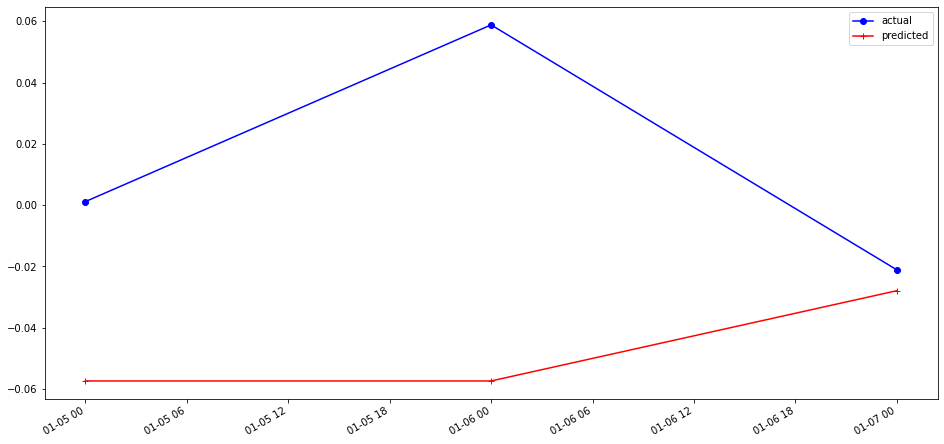

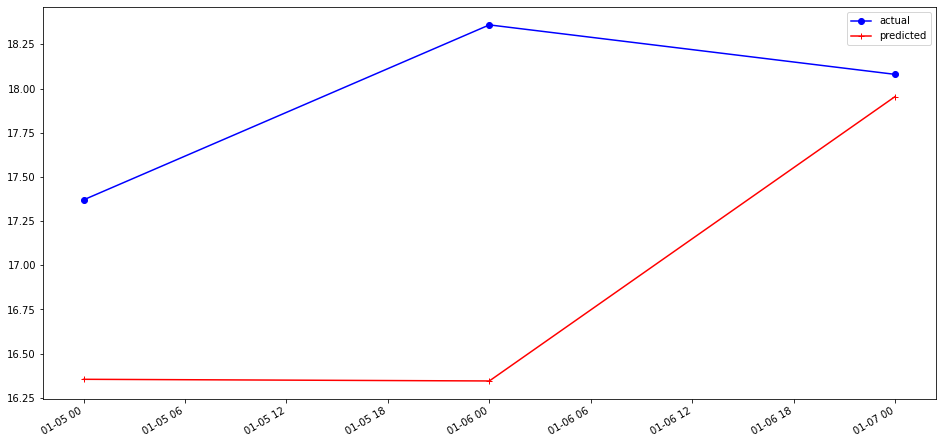

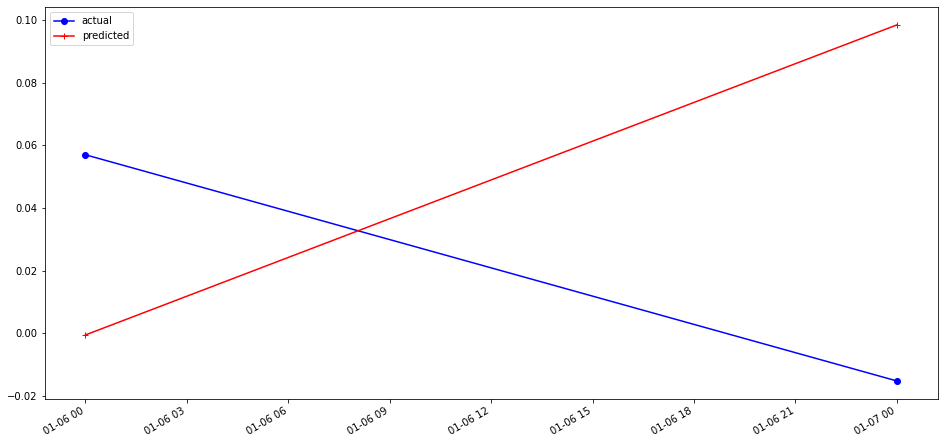

In [110]:
open_price = np.array(data.loc[:,'open'])

predicted_frac_change, _, _, _ = np.array(list(zip(*prediction)))
close_prediction = open_price * (1 + predicted_frac_change)
pred_return = pd.Series(close_prediction).pct_change().dropna().values.flatten().tolist()

actual_frac_change = np.array(HMM_stock_predictor.projection_data.frac_change)
close_actual = open_price * (1 + actual_frac_change)
actual_return = pd.Series(close_actual).pct_change().dropna().values.flatten().tolist()
# # actual_state = list(map(states_mapping,actual_return))
# # actual_state = [0 if v is None else v for v in actual_state]

fig = plt.figure(figsize=(16,8))
days = np.array(data.index, dtype="datetime64[ms]")
axes = fig.add_subplot(111)
axes.plot(days, actual_frac_change, 'bo-', label="actual")
axes.plot(days, predicted_frac_change, 'r+-', label="predicted")
fig.autofmt_xdate()

plt.legend()
plt.show()

fig = plt.figure(figsize=(16,8))
days = np.array(data.index, dtype="datetime64[ms]")
axes = fig.add_subplot(111)
axes.plot(days, close_actual, 'bo-', label="actual")
axes.plot(days, close_prediction, 'r+-', label="predicted")
fig.autofmt_xdate()

plt.legend()
plt.show()

fig = plt.figure(figsize=(16,8))
days = np.array(data.index[1:], dtype="datetime64[ms]")
axes = fig.add_subplot(111)
axes.plot(days, actual_return, 'bo-', label="actual")
axes.plot(days, pred_return, 'r+-', label="predicted")
fig.autofmt_xdate()

plt.legend()
plt.show()

In [111]:
r2_score(actual_frac_change, predicted_frac_change)

-3.9848610757853145

In [112]:
r2_score(close_actual, close_prediction)

-8.801088503814748

In [113]:
r2_score(actual_return, pred_return)

-5.2246628891415225